In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import soundfile as sf 
import pyfilterbank.gammatone as g
import SFA_Tools.SFA_Sets as s
import scipy.ndimage.filters as filt
from sklearn import svm
from sklearn.linear_model import Perceptron

The example STRF here is for an auditory neuron from the area CM (caudal medial) of a male zebra finch, when played conspecific birdsong. The colour of this plot shows the effect of sound on this neuron: this neuron tends to be excited by sound from about 2.5 kHz to 7 kHz heard by the animal 12 ms ago, but it is inhibited by sound in the same frequency range from about 18 ms ago.

<img src="STRF.JPG" alt="Drawing" style="width: 400px;"/>

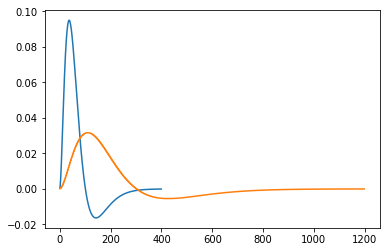

In [2]:
def gamma(n, a, b, m):
    arr = np.arange(1,n+1)
    return a*np.power(arr,m)*(np.exp(-b*arr))

def temporalFilter():
    arr = gamma(400,1.5,0.04,2) - gamma(400,1,0.036,2) 
    arr = arr / np.var(arr)
    return arr

def square(): 
    return np.zeros(1000) + 1

def scaled_noise(dataset, noise, ratio):
    data = dataset[0]
    for d in dataset:
        data = np.hstack((data,d))
    initial_ratio = np.sum(np.square(data))/np.sum(np.square(noise[:data.size]))
    return noise * np.sqrt(initial_ratio/ratio)

    

tFilter = temporalFilter()
tFilter2 = np.repeat(tFilter,3)/3
plt.plot(tFilter)
plt.plot(tFilter2)

In [3]:
file1 = 'coo.WAV'
file2 = 'grunt.WAV'
file3 = 'AG493B.WAV'
file4 = 'CS1E54.WAV'
noisefile = 'Matlab_SoundTextureSynth/Output_Folder/Bubbling_water_10111010100.wav'

data1, rate = sf.read(file1)
data2, rate = sf.read(file2)
data3, rate = sf.read(file3)
data4, rate = sf.read(file4)

noise, rate = sf.read(noisefile)
signal_to_noise = 100
noise = scaled_noise((data1,data2,data3,data4),noise,signal_to_noise)

In [4]:
gfb = g.GammatoneFilterbank(order=1, density = 1.0, startband = -21, endband = 21, normfreq = 2200)

analyse1 = gfb.analyze(data1)
analyse2 = gfb.analyze(data2)
analyse3 = gfb.analyze(data3)
analyse4 = gfb.analyze(data4)

analysenoise = gfb.analyze(noise)

transform1 = np.zeros((len(gfb.centerfrequencies),data1.size))
for i in range(len(gfb.centerfrequencies)):
    (band,state) = analyse1.__next__()
    transform1[i] = abs(band)

transform2 = np.zeros((len(gfb.centerfrequencies),data2.size))
for i in range(len(gfb.centerfrequencies)):
    (band,state) = analyse2.__next__()
    transform2[i] = abs(band)
    
transform3 = np.zeros((len(gfb.centerfrequencies),data3.size))
for i in range(len(gfb.centerfrequencies)):
    (band,state) = analyse3.__next__()
    transform3[i] = abs(band)
    
transform4 = np.zeros((len(gfb.centerfrequencies),data4.size))
for i in range(len(gfb.centerfrequencies)):
    (band,state) = analyse4.__next__()
    transform4[i] = abs(band)

transformNoise = np.zeros((len(gfb.centerfrequencies),noise.size))
for i in range(len(gfb.centerfrequencies)):
    (band,state) = analysenoise.__next__()
    transformNoise[i] = abs(band)

In [5]:
# plt.figure(figsize=(12,3))
# plt.imshow(transform1, aspect = 'auto')
# plt.figure(figsize=(12,3))
# plt.imshow(transform2, aspect = 'auto')
# plt.figure(figsize=(12,3))
# plt.imshow(transform3, aspect = 'auto')
# plt.figure(figsize=(12,3))
# plt.imshow(transform4, aspect = 'auto')

In [6]:
transform1 = filt.convolve(transform1,tFilter[:,None].T)
transform2 = filt.convolve(transform2,tFilter[:,None].T)
transform3 = filt.convolve(transform3,tFilter[:,None].T)
transform4 = filt.convolve(transform4,tFilter[:,None].T)
noise1 =  filt.convolve(transformNoise,tFilter[:,None].T)

transform12 = filt.convolve(transform1,tFilter2[:,None].T)
transform22 = filt.convolve(transform2,tFilter2[:,None].T)
transform32 = filt.convolve(transform3,tFilter2[:,None].T)
transform42 = filt.convolve(transform4,tFilter2[:,None].T)
noise2 =  filt.convolve(transformNoise,tFilter2[:,None].T)

transform1 = np.vstack((transform1,transform12))
transform2 = np.vstack((transform2,transform22))
transform3 = np.vstack((transform3,transform32))
transform4 = np.vstack((transform4,transform42))
noise = np.vstack((noise1,noise2))

t1 = transform1[:,0:12000]
t2 = transform2[:,13000:23000]
t3 = transform3[:,1000:8000]
t4 = transform4[:,10000:14000]

t1 = t1[:,::40]
t2 = t2[:,::40]
t3 = t3[:,::40]
t4 = t4[:,::40]
transform1 = transform1[:,::40]
transform2 = transform2[:,::40]


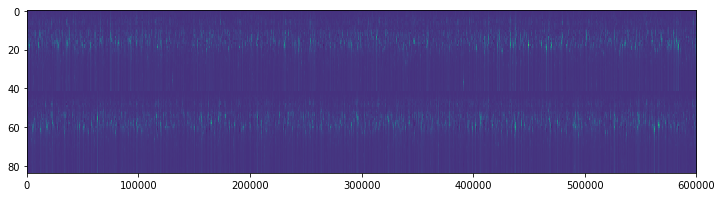

In [28]:
# plt.figure(figsize=(12,3))
# plt.imshow(t1, aspect = 'auto')
# plt.figure(figsize=(12,3))
# plt.imshow(t2, aspect = 'auto')
# plt.figure(figsize=(12,3))
# plt.imshow(t3, aspect = 'auto')
# plt.figure(figsize=(12,3))
# plt.imshow(t4, aspect = 'auto')
plt.figure(figsize=(12,3))
plt.imshow(noise,aspect='auto')

In [29]:
t = [t1,t2,t3,t4]
length = 4 * 30
samples = np.random.randint(4, size = length)
vocal = t1
for i in samples:
    vocal = np.concatenate((vocal, t[i]),1)
#     vocal = np.concatenate((vocal, np.zeros((vocal.shape[0], np.random.randint(25,100)))),1)
vocal = vocal + 0.05*noise[:,0:vocal[0].size]
vocal = vocal + np.random.normal(0,0.5,vocal.shape)
vocal1 = vocal[:,0:vocal[0].size - 30]
vocal2 = vocal[:,30:]


In [30]:
(xnorm1,m1,var1) = s.norm(vocal1)
# (xnorm2,m2,var2) = s.norm(x2)
print('Xnorm Complete...')
xquad = s.quadExpand(xnorm1)
print('XQuad Complete...')
(xpca,SS) = s.PCA(xquad)
print('Sphering Complete...')
xweights = s.weights(xpca, 20)
print('Weights Determined...')
xweights = np.flip(xweights.T,0)

Xnorm Complete...
XQuad Complete...
Sphering Complete...
Weights Determined...


In [31]:
(xnorm2,m2,var2) = s.norm(vocal2)
# (xnorm2,m2,var2) = s.norm(x2)
print('Xnorm Complete...')
xquad2 = s.quadExpand(xnorm1)
print('XQuad Complete...')
(xpca2,SS2) = s.PCA(xquad2)
print('Sphering Complete...')
xweights2 = s.weights(xpca2, 20)
print('Weights Determined...')
xweights2 = np.flip(xweights2.T,0)

Xnorm Complete...
XQuad Complete...
Sphering Complete...
Weights Determined...


In [32]:
g1 = np.matmul(xweights, xpca)
g2 = np.matmul(xweights2, xpca2)

x3 = np.vstack((g1,g2))
(xnorm3,m3,var3) = s.norm(x3)
print('Xnorm Complete...')
xquad3 = s.quadExpand(xnorm3)
print('XQuad Complete...')
(xpca3,SS3) = s.PCA(xquad3)
print('Sphering Complete...')
xweights3 = s.weights(xpca3, 20)
print('Weights Determined...')
xweights3 = np.flip(xweights3.T,0)
g3 = np.matmul(xweights3,xpca3)

Xnorm Complete...
XQuad Complete...
Sphering Complete...
Weights Determined...


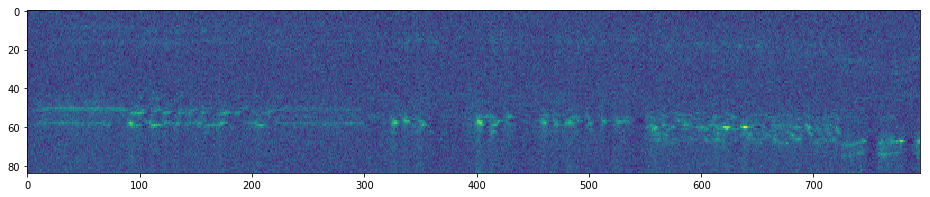

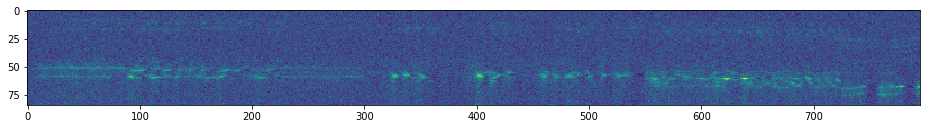

In [33]:
test = np.concatenate((t1,t2,t3,t4),1)
test = test +  0.05*noise[:,0:test[0].size]
# test = test + np.random.normal(0,0.5,test.shape)
alt_test =np.concatenate((transform1,transform2),1)
tsize = t1[0].size
test1 = test[:,0:test[0].size - 30]
test2 = test[:,30:]
plt.figure(figsize=(16,3))
plt.imshow(test1, aspect = 'auto')
plt.figure(figsize=(16,3))
plt.imshow(test1 + 0.05*noise[:,0:test1[0].size])
# plt.imshow(test1 + np.random.normal(0,0.5,test1.shape))


In [34]:
newNorm = s.normTest(test1,m1,var1) 
print('Xnorm Complete...')
newQuad = s.quadExpand(newNorm)
print('XQuad Complete...')
xpca = s.PCATest(newQuad,SS)
print('Sphering Complete...')

newNorm2 = s.normTest(test2,m2,var2) 
print('Xnorm Complete...')
newQuad2 = s.quadExpand(newNorm2)
print('XQuad Complete...')
xpca2 = s.PCATest(newQuad2,SS2)
print('Sphering Complete...')

test_g1 = np.matmul(xweights, xpca)
test_g2 = np.matmul(xweights2, xpca2)

test3 = np.vstack((test_g1,test_g2))
newNorm3 = s.normTest(test3,m3,var3) 
print('Xnorm Complete...')
newQuad3 = s.quadExpand(newNorm3)
print('XQuad Complete...')
xpca3 = s.PCATest(newQuad3,SS3)
print('Sphering Complete...')
test_g3 = np.matmul(xweights3, xpca3)

Xnorm Complete...
XQuad Complete...
Sphering Complete...
Xnorm Complete...
XQuad Complete...
Sphering Complete...
Xnorm Complete...
XQuad Complete...
Sphering Complete...


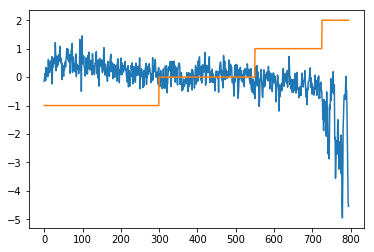

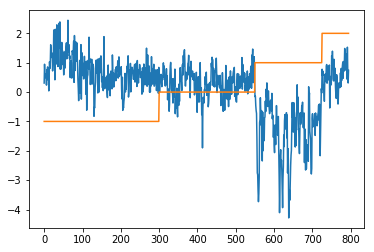

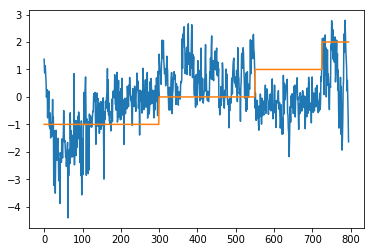

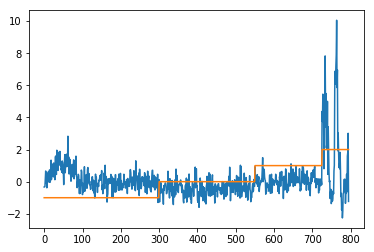

In [35]:
one = np.zeros(t1[0].size)
two = np.ones(t2[0].size)
three = np.ones(t3[0].size) * 2
four = np.ones(t4[0].size-30)*3
identity = np.hstack((one,two,three,four))
for i in range(4):
    plt.plot(test_g1[i])
    plt.plot(identity-1)
    plt.show()

In [45]:
# model = svm.SVC(C=1.0, kernel='linear')
model = svm(max_iter = 1000, tol = 0.001)
n = 4
model.fit(test_g1[:n].T,identity)
print(model.score(test_g1[:n].T,identity))

# model2 = svm.SVC(C=1.0, kernel='linear')
model2 = Perceptron(max_iter = 1000, tol = 0.001)
model2.fit(test1.T,identity)
print(model2.score(test1.T,identity))

0.8113207547169812
0.879245283018868


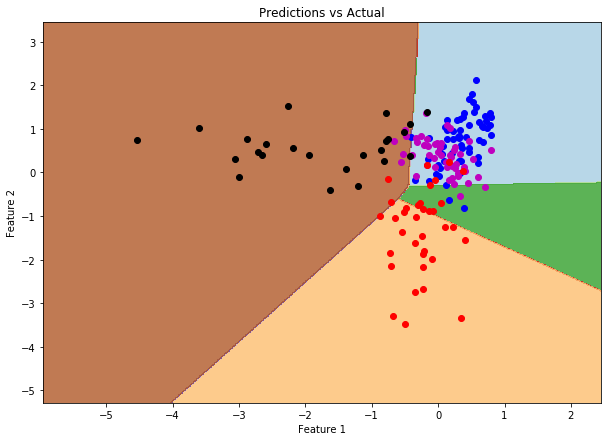

In [39]:
# create a mesh to plot in
x_min, x_max = test_g1[0].min() - 1, test_g1[0].max() + 1
y_min, y_max = test_g1[1].min() - 1, test_g1[1].max() + 1
n = 500
xx, yy = np.meshgrid(np.linspace(x_min, x_max, n), np.linspace(y_min, y_max, n))

plt.figure(figsize=(10,7))
arr = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(arr)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)

plt.scatter(test_g1[0,:t1[0].size:5], test_g1[1,:t1[0].size:5], c='b', cmap=plt.cm.Paired)
plt.scatter(test_g1[0,t1[0].size:t1[0].size+t2[0].size:5], test_g1[1,t1[0].size:t1[0].size+t2[0].size:5], c='m', cmap=plt.cm.Paired)
plt.scatter(test_g1[0,t1[0].size+t2[0].size:t1[0].size+t2[0].size+t3[0].size:5], test_g1[1,t1[0].size+t2[0].size:t1[0].size+t2[0].size+t3[0].size:5], c='r', cmap=plt.cm.Paired)
plt.scatter(test_g1[0,t1[0].size+t2[0].size+t3[0].size:t1[0].size+t2[0].size+t3[0].size+t4[0].size-30:3], test_g1[1,t1[0].size+t2[0].size+t3[0].size:t1[0].size+t2[0].size+t3[0].size+t4[0].size-30:3], c='black', cmap=plt.cm.Paired)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.xlim(xx.min(), xx.max())
plt.title('Predictions vs Actual')
plt.show()